# How does the weather influence my Social Media behavior?
Mental well-being might well be tied to the weather, e.g. you might be feeling blue after days of rain without a break. Similarly, your social media behaviour might be tied to the weather. E.g. you might post less if you're outside enjoying the sun. Or you might post more up-beat posts when the weather's nice. 

This notebook brings together the data from your Twitter archive and your GPS data from Moves to correlate your Twitter and Weather data. 

For this notebook to work you need to have both the [Twitter Archive Analyser](https://www.openhumans.org/activity/twitter-archive-analyzer/) and the [Moves connection](https://www.openhumans.org/activity/moves-connection/) added to your *Open Humans* account and already need to have this data available in your account (i.e. you need to have uploaded your Twitter archive on the Twitter archive analyser site and need to have connected your Moves account to your Open Humans account).

The weather data comes from *Dark Sky* and their API. You will need a `DARKSKY_KEY` for their API to use this notebook. You can [create one for free on their website](https://darksky.net/dev). Dark Sky allows you to make 1,000 calls per day for free. This notebook makes at worst 1 call for each day that is in your `DATARANGE`. So the 1,000 calls can get you ~ 2 1/2 years of local weather data. Once you have made an account you can enter you `DARKSKY_KEY` in the cell below. 

The `DATARANGE_START` and `DATARANGE_END` give the boundaries for which your analysis should be run (in `YYYY-MM-DD` format). Choose the values so that you have some *Moves* data between those boundaries and also that you're not requesting too much data from *Dark Sky* (or pay for requesting more data from *dark sky*, after the first 1,000 calls each day of weather data will be USD 0.0001).

You might consider paying for additional API calls to *Dark Sky* as it's rather cheap: Making 10,000 calls costs US $1.00 and you can [set up daily usage limits](https://darksky.net/dev/account/edit) to make sure you don't accumulate too much costs.

In [1]:
DARKSKY_KEY = 'ENTER_YOUR_KEY_HERE'
DATARANGE_START = "2016-06-01"
DATARANGE_END = "2018-05-08"

Let's load our dependencies for getting & analysing the *Moves* and *Twitter Archive* data

In [2]:
import os
import json
import requests
from datetime import datetime
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tempfile
import zipfile
import pytz
import io
import sys
from textblob import TextBlob
import emoji


# sets the axis label sizes for seaborn
rc={'font.size': 14, 'axes.labelsize': 14, 'legend.fontsize': 14.0, 
    'axes.titlesize': 14, 'xtick.labelsize': 14, 'ytick.labelsize': 14}
sns.set(rc=rc)

## Processing the Twitter archive data
All the functions are already provided by http://twarxiv.org and we just copied the functions from there. It will basically take a zipped archive from a URL and return a nicely formatted `pandas` dataframe. Let's just take these as given for now:

In [3]:
# THIS CODE BELOW IS COPIED FROM TWARXIV.ORG AS IT ALREADY DOES EXACTLY WHAT WE WANT FOR READING IN THE DATA

# READ JSON FILES FROM TWITTER ARCHIVE!

def check_hashtag(single_tweet):
    '''check whether tweet has any hashtags'''
    return len(single_tweet['entities']['hashtags']) > 0


def check_media(single_tweet):
    '''check whether tweet has any media attached'''
    return len(single_tweet['entities']['media']) > 0


def check_url(single_tweet):
    '''check whether tweet has any urls attached'''
    return len(single_tweet['entities']['urls']) > 0


def check_retweet(single_tweet):
    '''
    check whether tweet is a RT. If yes:
    return name & user name of the RT'd user.
    otherwise just return nones
    '''
    if 'retweeted_status' in single_tweet.keys():
        return (single_tweet['retweeted_status']['user']['screen_name'],
                single_tweet['retweeted_status']['user']['name'])
    else:
        return (None, None)


def check_coordinates(single_tweet):
    '''
    check whether tweet has coordinates attached.
    if yes return the coordinates
    otherwise just return nones
    '''
    if 'coordinates' in single_tweet['geo'].keys():
        return (single_tweet['geo']['coordinates'][0],
                single_tweet['geo']['coordinates'][1])
    else:
        return (None, None)


def check_reply_to(single_tweet):
    '''
    check whether tweet is a reply. If yes:
    return name & user name of the user that's replied to.
    otherwise just return nones
    '''
    if 'in_reply_to_screen_name' in single_tweet.keys():
        name = None
        for user in single_tweet['entities']['user_mentions']:
            if user['screen_name'] == single_tweet['in_reply_to_screen_name']:
                name = user['name']
                break
        return (single_tweet['in_reply_to_screen_name'], name)
    else:
        return (None, None)


def create_dataframe(tweets):
    '''
    create a pandas dataframe from our tweet jsons
    '''

    # initalize empty lists
    utc_time = []
    longitude = []
    latitude = []
    hashtag = []
    media = []
    url = []
    retweet_user_name = []
    retweet_name = []
    reply_user_name = []
    reply_name = []
    text = []
    # iterate over all tweets and extract data
    for single_tweet in tweets:
        utc_time.append(datetime.strptime(single_tweet['created_at'],
                                                   '%Y-%m-%d %H:%M:%S %z'))
        coordinates = check_coordinates(single_tweet)
        latitude.append(coordinates[0])
        longitude.append(coordinates[1])
        hashtag.append(check_hashtag(single_tweet))
        media.append(check_media(single_tweet))
        url.append(check_url(single_tweet))
        retweet = check_retweet(single_tweet)
        retweet_user_name.append(retweet[0])
        retweet_name.append(retweet[1])
        reply = check_reply_to(single_tweet)
        reply_user_name.append(reply[0])
        reply_name.append(reply[1])
        text.append(single_tweet['text'])
    # convert the whole shebang into a pandas dataframe
    dataframe = pd.DataFrame(data={
                            'utc_time': utc_time,
                            'latitude': latitude,
                            'longitude': longitude,
                            'hashtag': hashtag,
                            'media': media,
                            'url': url,
                            'retweet_user_name': retweet_user_name,
                            'retweet_name': retweet_name,
                            'reply_user_name': reply_user_name,
                            'reply_name': reply_name,
                            'text': text
    })
    return dataframe


def read_files(zip_url):
    tf = tempfile.NamedTemporaryFile()
    print('downloading files')
    tf.write(requests.get(zip_url).content)
    tf.flush()
    zf = zipfile.ZipFile(tf.name)
    print('reading index')
    with zf.open('data/js/tweet_index.js', 'r') as f:
        f = io.TextIOWrapper(f)
        d = f.readlines()[1:]
        d = "[{" + "".join(d)
        json_files = json.loads(d)
    data_frames = []
    print('iterate over individual files')
    for single_file in json_files:
        print('read ' + single_file['file_name'])
        with zf.open(single_file['file_name']) as f:
            f = io.TextIOWrapper(f)
            d = f.readlines()[1:]
            d = "".join(d)
            tweets = json.loads(d)
            df_tweets = create_dataframe(tweets)
            data_frames.append(df_tweets)
    return data_frames


def create_main_dataframe(zip_url='http://ruleofthirds.de/test_archive.zip'):
    print('reading files')
    dataframes = read_files(zip_url)
    print('concatenating...')
    dataframe = pd.concat(dataframes)
    dataframe = dataframe.sort_values('utc_time', ascending=False)
    dataframe = dataframe.set_index('utc_time')
    dataframe = dataframe.replace(to_replace={
                                    'url': {False: None},
                                    'hashtag': {False: None},
                                    'media': {False: None}
                                    })
    return dataframe


## Processing the Moves data
This is copied more or less verbatim from the `moves-analysis.ipynb` notebook that's a Personal Data Notebook example. Let's take this code for given right now too: 

In [4]:
weather_cache = {}

def longest_daily_location(daily_segments):
    """
    takes a daily segment log of Moves and returns the 
    lat/long for the location where most time was spent. 
    Can be misleading for days w/ lots of travel etc. 
    But the most quick/dirty solution for now.
    """
    places_of_day = []
    for i in daily_segments:
        if i['type'] == 'place':
            place_location = i['place']['location']
            start_time = datetime.strptime(i['startTime'],'%Y%m%dT%H%M%S%z')
            end_time = datetime.strptime(i['endTime'],'%Y%m%dT%H%M%S%z')
            duration = end_time - start_time
            places_of_day.append([place_location,duration])
    places_of_day.sort(key=lambda tup: tup[-1],reverse=True)
    return places_of_day[0][0]

def weather_for_location_day(location, date):
    """
    take a location as returned by longest_daily_location 
    and a date of YYYYMMDD to get the weather from the 
    Dark Sky API. Does not do any filtering yet
    """
    if DARKSKY_KEY == 'ENTER_YOUR_KEY_HERE':
        raise ValueError("Oops, you didn't add your Dark Sky API key! "
              "Scroll back up to the first step in this notebook. :)")
    date = '{}-{}-{}T12:00:00'.format(
    date[:4],
    date[4:6],
    date[6:8])

    if date not in weather_cache:
        url = 'https://api.darksky.net/forecast/{}/{},{},{}?units=si'.format(DARKSKY_KEY,
            location['lat'],
            location['lon'],
            date
        )
        response = requests.get(url)
        weather_cache[date] = response.json()

    return weather_cache[date]

## Importing *Moves* and *Twitter Data*
We can now start importing our data from the two data sources. The *Twitter* data will already come in a nicely packaged data frame. For the *Moves* data we will have to make our weather API calls afterwards. 

In [5]:
response = requests.get("https://www.openhumans.org/api/direct-sharing/project/exchange-member/?access_token={}".format(os.environ.get('OH_ACCESS_TOKEN')))
user = json.loads(response.content)

has_twitter = False
has_moves = False

# get our download URLs
for entry in user['data']:
    if entry['source'] == "direct-sharing-70":
        twitter_data_url = entry['download_url']
        has_twitter = True
    if entry['source'] == "direct-sharing-138":
        moves_data_url = entry['download_url']
        has_moves = True

if not has_twitter:
    print("YOU NEED TO HAVE SOME TWITTER DATA IN YOUR ACCOUNT TO USE THIS NOTEBOOK")
    print("GO TO http://twarxiv.org TO UPLOAD IT")

if not has_twitter:
    print("YOU NEED TO HAVE SOME MOVES DATA IN YOUR ACCOUNT TO USE THIS NOTEBOOK")
    print("GO TO https://ohmovessource.herokuapp.com/ TO UPLOAD IT")
    
# read the twitter data
twitter_data = create_main_dataframe(zip_url=twitter_data_url)

# read the moves data
moves_data_raw = requests.get(moves_data_url).content
moves_data = json.loads(moves_data_raw)

reading files
downloading files
reading index
iterate over individual files
read data/js/tweets/2018_03.js
read data/js/tweets/2018_02.js
read data/js/tweets/2018_01.js
read data/js/tweets/2017_12.js
read data/js/tweets/2017_11.js
read data/js/tweets/2017_10.js
read data/js/tweets/2017_09.js
read data/js/tweets/2017_08.js
read data/js/tweets/2017_07.js
read data/js/tweets/2017_06.js
read data/js/tweets/2017_05.js
read data/js/tweets/2017_04.js
read data/js/tweets/2017_03.js
read data/js/tweets/2017_02.js
read data/js/tweets/2017_01.js
read data/js/tweets/2016_12.js
read data/js/tweets/2016_11.js
read data/js/tweets/2016_10.js
read data/js/tweets/2016_09.js
read data/js/tweets/2016_08.js
read data/js/tweets/2016_07.js
read data/js/tweets/2016_06.js
read data/js/tweets/2016_05.js
read data/js/tweets/2016_04.js
read data/js/tweets/2016_03.js
read data/js/tweets/2016_02.js
read data/js/tweets/2016_01.js
read data/js/tweets/2015_12.js
read data/js/tweets/2015_11.js
read data/js/tweets/2015_

Let's quickly look at the Twitter dataframe to see whether the data was loaded correctly:

In [6]:
twitter_data.head()

,hashtag,latitude,longitude,media,reply_name,reply_user_name,retweet_name,retweet_user_name,text,url
utc_time,,,,,,,,,,
2018-03-28 17:19:54+00:00,NaN,NaN,NaN,1.0,None,None,David Gerard,davidgerard,RT @davidgerard: new dimensions in ICO scams: ...,NaN
2018-03-28 16:51:03+00:00,NaN,37.8737,-122.257,NaN,Michael Fe3+,mbeisen,None,None,@mbeisen @michaelhoffman @mmcwatters the futur...,1.0
2018-03-28 16:45:32+00:00,NaN,37.8737,-122.256,NaN,yo yehudi🏳️‍🌈🇪🇺,yoyehudi,None,None,@yoyehudi I took the easy route: amazon :D,NaN
2018-03-28 16:38:41+00:00,NaN,37.8737,-122.257,NaN,Timothée Poisot,tpoi,None,None,@tpoi How much I hate “trivial”!,NaN
2018-03-28 16:01:31+00:00,NaN,37.8632,-122.273,NaN,Jason Williams,JasonWilliamsNY,None,None,"@JasonWilliamsNY Absolutely, but this one has ...",NaN


If this looks good we can now go ahead and import the weather data from the Dark Sky's API and convert the data into a data frame too:

In [7]:

weather_variables  = ['precipType','precipIntensity','temperatureHigh',
                      'temperatureLow','precipIntensityMax','precipAccumulation',
                      'apparentTemperatureHigh', 'apparentTemperatureLow']

moves_processed_data = defaultdict(list)

for datapoint in moves_data:
    # we need to have observed segments for that day. If moves wasn't running we ignore the day
    if datapoint['segments'] != None:
        # did we stay in a place that day and did we walk that day?
        has_places = False
        walked = False
        for i in datapoint['segments']:
            if i['type'] == 'place':
                    # yes, we were in one place w/o moving around too much, we can keep this day
                    has_places = True
        # is this day in our date range of interest and has data?
        if datapoint['summary'] != None and has_places and datetime.strptime(datapoint['date'],"%Y%m%d") > datetime.strptime(DATARANGE_START,"%Y-%m-%d"):
            moves_processed_data['date'].append(datapoint['date'])
            for activity in datapoint['summary']:
                if activity['activity'] == 'walking':
                    moves_processed_data['steps'].append(activity['steps'])
                    moves_processed_data['distance'].append(activity['distance'])
                    walked = True
            # whops, we have moves data for this day but moves didn't register you walking & your step count is zero
            if not walked:
                moves_processed_data['steps'].append(0)
                moves_processed_data['distance'].append(0)    
            # grab the location where we spent most time as baseline geo location for the day
            location = longest_daily_location(datapoint['segments'])
            moves_processed_data['lat'].append(location['lat'])
            moves_processed_data['lon'].append(location['lon'])
            # now we can grab the weather for our baseline location
            weather = weather_for_location_day(location,datapoint['date'])
            for variable in weather_variables:
                if variable in weather['daily']['data'][0].keys():
                    moves_processed_data[variable].append(weather['daily']['data'][0][variable])
                else:
                    moves_processed_data[variable].append(0)
            if datetime.strptime(datapoint['date'],"%Y%m%d") > datetime.strptime(DATARANGE_END,"%Y-%m-%d"):
                break

moves_dataframe = pd.DataFrame(data={
    'date': moves_processed_data['date'],
    'steps': moves_processed_data['steps'],
    'distance': moves_processed_data['distance'],
    'latitude': moves_processed_data['lat'],
    'longitude': moves_processed_data['lon'],
    'precipType': moves_processed_data['precipType'],
    'precipIntensity': moves_processed_data['precipIntensity'],
    'precipIntensityMax': moves_processed_data['precipIntensityMax'],
    'precipAccumulation': moves_processed_data['precipAccumulation'],
    'temperatureHigh': moves_processed_data['temperatureHigh'],
    'temperatureLow': moves_processed_data['temperatureLow'],
    'apparentTemperatureHigh': moves_processed_data['apparentTemperatureHigh'],
    'apparentTemperatureLow': moves_processed_data['apparentTemperatureLow']

})

Let's check whether the *Moves* weather look up worked out:

In [8]:
moves_dataframe.head()

,apparentTemperatureHigh,apparentTemperatureLow,date,distance,latitude,longitude,precipAccumulation,precipIntensity,precipIntensityMax,precipType,steps,temperatureHigh,temperatureLow
0,18.01,10.72,20160617,1759.0,50.060944,8.818717,0.0,0.2515,3.5230,rain,992,18.01,10.72
1,18.11,11.41,20160618,5413.0,50.060944,8.818717,0.0,0.1499,1.8009,rain,6730,18.11,11.41
2,17.45,7.46,20160619,6471.0,50.060944,8.818717,0.0,0.0076,0.1575,rain,6395,17.45,7.83
3,21.37,13.95,20160620,4613.0,50.060944,8.818717,0.0,0.2235,2.7127,rain,4377,21.37,13.95
4,21.62,17.37,20160621,2238.0,50.114025,8.753432,0.0,0.2235,2.3520,rain,2673,21.62,17.10


If that looks good we can now do a quick sentiment prediction for our *Twitter* data:

In [9]:
polarity = []
subjectivity = []
twitter_data['blob'] = twitter_data['text'].apply(TextBlob)
for entry in twitter_data['blob']:
    polarity.append(entry.sentiment.polarity)
    subjectivity.append(entry.sentiment.subjectivity)
twitter_data['polarity'] = polarity
twitter_data['subjectivity'] = subjectivity
twitter_data = twitter_data.replace(0, np.nan)

Let's now grab the mean sentiment per day and the number of tweets per day and store all of that in `twitter_mean`:

In [10]:
twitter_data['date'] = twitter_data.index.date
tweets_per_day = twitter_data['date'].value_counts()
twitter_mean = twitter_data.groupby(twitter_data.index.date).mean()
twitter_mean = twitter_mean.join(tweets_per_day)

In [11]:
twitter_mean.head()

,hashtag,latitude,longitude,media,url,polarity,subjectivity,date
2008-04-02,NaN,NaN,NaN,NaN,NaN,0.422222,0.644444,2
2008-04-03,NaN,NaN,NaN,NaN,NaN,0.016667,0.916667,12
2008-04-04,NaN,NaN,NaN,NaN,NaN,-0.333333,0.666667,9
2008-04-05,NaN,NaN,NaN,NaN,NaN,0.500000,1.000000,6
2008-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


Now we need to set the index for the *Moves* data correctly so that we can join our two dataframes on it. To do that we need to correctly parse the `date` column.

In [12]:
moves_dataframe['date'] = moves_dataframe['date'].apply(lambda x: datetime.strptime(x,"%Y%m%d"))
moves_dataframe.index = moves_dataframe['date']
twitter_moves = twitter_mean.join(moves_dataframe,lsuffix='_twitter',rsuffix='_moves',how='right')

# Polarity/Subjectivity in relation to felt temperature
And with that we are ready to plot how our `polarity` and `subjectivity` is dependent e.g. on the `apparentTemperatureHigh`:

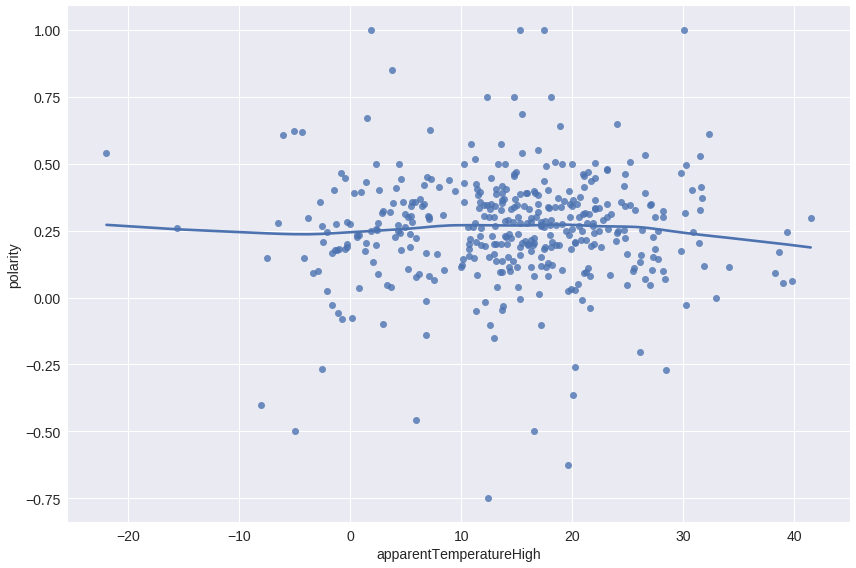

In [13]:
sns.lmplot(x="apparentTemperatureHigh", y="polarity", data=twitter_moves,lowess=True,size=8,aspect=1.5)

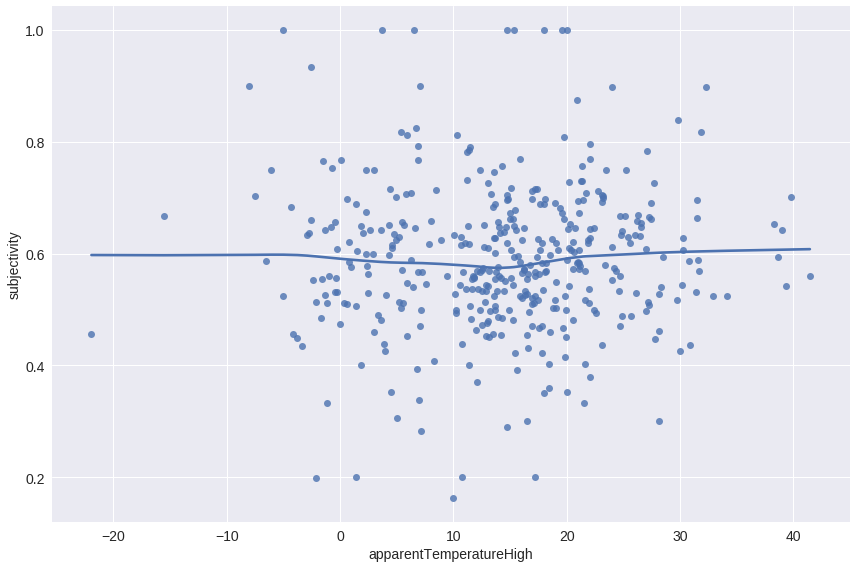

In [14]:
sns.lmplot(x="apparentTemperatureHigh", y="subjectivity", data=twitter_moves,lowess=True,size=8,aspect=1.5)

There seems to be very little interaction between the perceived temperature and the polarity/subjectivity. So, maybe it's more a function of how wet it's outside?

# Tears in the rain: Polarity/Subjectivity in relation to percipitation
Let's just plot `polarity` and `subjectivity` in relation to the presence/absence of any percipitation outside:

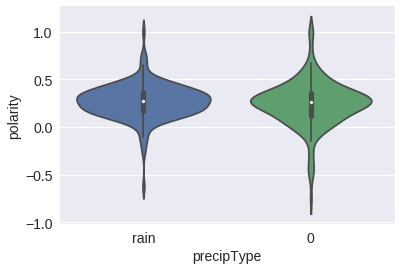

In [15]:
sns.violinplot(x='precipType',
               y='polarity',
               data=twitter_moves[twitter_moves['precipType'] != 'snow'])

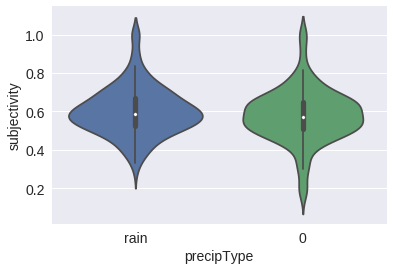

In [16]:
sns.violinplot(x='precipType',
               y='subjectivity',
               data=twitter_moves[twitter_moves['precipType'] != 'snow'])

In [17]:
from scipy.stats import mannwhitneyu

twitter_moves

rain = twitter_moves[twitter_moves['precipType'] == 'rain']
clear = twitter_moves[twitter_moves['precipType'] == 0]
polarity_results = mannwhitneyu(rain['polarity'], clear['polarity'],alternative='two-sided')
subjectivity_results  = mannwhitneyu(rain['subjectivity'], clear['subjectivity'],alternative='two-sided')
print('the p-value for a subjectivity-difference between rain & shine is {}'.format(subjectivity_results.pvalue))
print('--')
print('the p-value for a polarity-difference between rain & shine is {}'.format(polarity_results.pvalue))

the p-value for a subjectivity-difference between rain & shine is 0.827896273529459
--
the p-value for a polarity-difference between rain & shine is 0.9882673041937862


Neither the plots themselves nor the `mannwhitneyu` statistical test offers any evidence for the weather influencing the `polarity` or `subjectivity` of tweets in this case. ☔️✨☀️🌈

## Tweets per Day & the Weather

Let's now check whether the weather impacts how many tweets per day are being sent. Given that my own Twitter frequency fluctuates a lot over the years I want to limit myself to the year 2016 for the analysis:

In [18]:
tweet_year = "2016"
# you can get these values from Google Maps by clicking on a point and copy&pasting the values 
# from the URL/bottom information box

target_latitude = 50.114462 # If you're south of the equator this one should start with "-"
target_longitude = 8.746019 # If you're west of the prime meridian this should also start with a "-"
km_distance = 25 # we don't want to be too strict in filtering. 

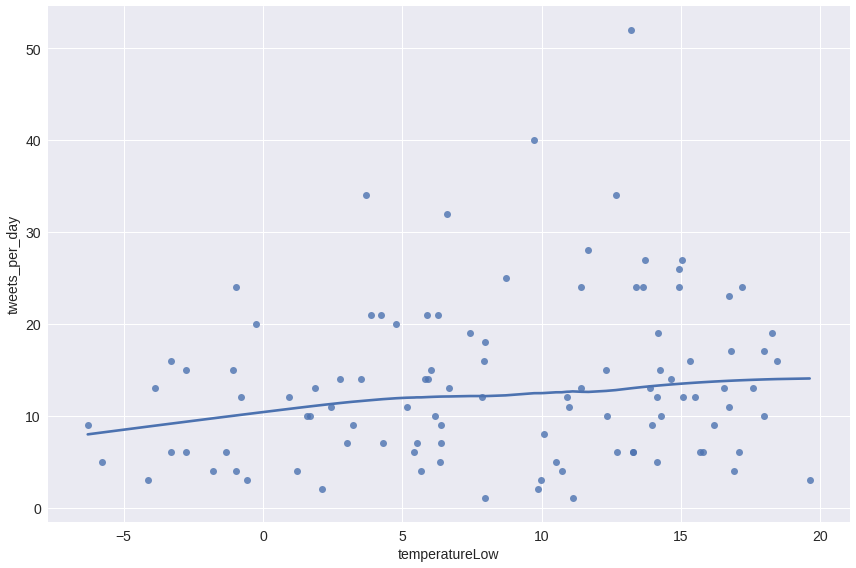

In [19]:
# earth's radius in km = ~6371
earth_radius = 6371

# latitude boundaries
maxlat = target_latitude + np.rad2deg(km_distance / earth_radius)
minlat = target_latitude - np.rad2deg(km_distance / earth_radius)

#longitude boundaries (longitude gets smaller when latitude increases)
maxlng = target_longitude + np.rad2deg(km_distance / earth_radius / np.cos(np.deg2rad(target_latitude)))
minlng = target_longitude - np.rad2deg(km_distance / earth_radius / np.cos(np.deg2rad(target_latitude)))

twitter_moves['tweets_per_day'] = twitter_moves['date_twitter'] 
twitter_moves_subset = twitter_moves[(twitter_moves.index.year == int(tweet_year)) & 
                                    (twitter_moves['longitude_moves'] >= minlng) & 
                                    (twitter_moves['longitude_moves'] < maxlng) &
                                    (twitter_moves['latitude_moves'] < maxlat) & 
                                    (twitter_moves['latitude_moves'] > minlat)]


sns.lmplot(x="temperatureLow", y="tweets_per_day", data=twitter_moves_subset,lowess=True,size=8,aspect=1.5)

There seems to be somewhat of a positive correlation between the temperature and the number of tweets per day. But how does it correlate to the presence of precipitation?

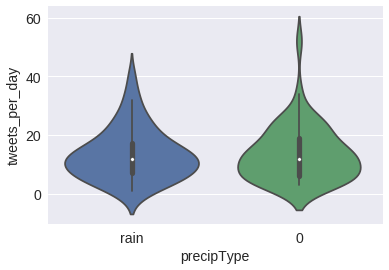

In [21]:
sns.violinplot(x='precipType',
               y='tweets_per_day',
               data=twitter_moves_subset[twitter_moves_subset['precipType'] != 'snow'])

While there is a slight trend it overall seems that Twitter isn't just for rainy days after all but is also happily used on sunny days. ☀️